In [1]:
import sys,os
sys.path.append('/home/marc/flow_ssl/')
import glob
import torch,dill
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from invertible.iresnet import iResBlock
from invertible.iEluNetwork import iConv2d,iSLReLU
from invertible.spectral_norm import SN
from invertible.downsample import SqueezeLayer,split,merge,padChannels,keepChannels,NNdownsample,iAvgPool2d
from invertible.clipped_BN import MeanOnlyBN, iBN
import numpy as np
import seaborn as sb
import torch.nn.functional as F
import pandas as pd
import timeit

In [2]:
bs = 32
c = 64
h = w = 8
Conv = iConv2d(c,c)

In [ ]:
x = torch.randn(64,c,h,w)

In [ ]:
y = Conv(x)

In [ ]:
%timeit Conv.logdet()

In [ ]:
%timeit Conv(x)

In [ ]:
with torch.no_grad():
    %timeit Conv.inverse(x)

In [3]:
bs = 32
c = 64
h = w = 8
Conv = iConv2d(c,c)
with torch.no_grad():
    for c in []:
        print(f"Timings for c = {c}")
        Conv = iConv2d(c,c).cuda()
        x = torch.randn(bs,c,h,w).cuda()
        print("conv")
        %timeit Conv(x)
        y=Conv(x)
        print("logdet")
        %timeit ld = Conv.logdet()
        print("inverse")
        %timeit x0 = Conv.inverse(y)
    
    c = 64
    Conv = iConv2d(c,c).cuda()
    for h in []:
        w=h
        print(f"Timings for h,w = {h}")
        x = torch.randn(bs,c,h,w).cuda()
        print("conv")
        %timeit Conv(x)
        y=Conv(x)
        print("logdet")
        %timeit ld = Conv.logdet()
        print("inverse")
        %timeit x0 = Conv.inverse(y)

In [4]:
channels = np.array([16,32,64,128,256,512,1024])
inverse_times_c = np.array([3440,9590,37700,133000,499000,2270000,11400000])
#inverse_sigmas_c = np.array([445,456,10200,5180])
logdet_times_c = np.array([397,397,1290,6340,23800,84900,390000])
#logdet_sigmas_c = np.array([.6,35,32,78])
conv_times_c = np.array([144,144,144,143,390,1270,4760])

height = np.array([4,8,16,32,64,128])
inverse_times_h = np.array([6750,32600,162000,727000,2930000,13500000])
#inverse_sigmas_h = np.array([78,2000,5000,16000,70000])
logdet_times_h = np.array([755,1300,3300,13400,54400,238000])
#logdet_sigmas_h = np.array([53,40,3,100,400])
conv_times_h = np.array([143,143,142,475,1670,6280])

In [ ]:
df_channels = pd.DataFrame({'channels':channels,
                            'inverse_times':inverse_times_c,'inverse_sigmas':inverse_sigmas_c,
                            'logdet_times':logdet_times_c,'logdet_sigmas':logdet_sigmas_c,
                           'conv_times':conv_times_c})

In [ ]:
df_channels.plot(x='channels',loglog=True)

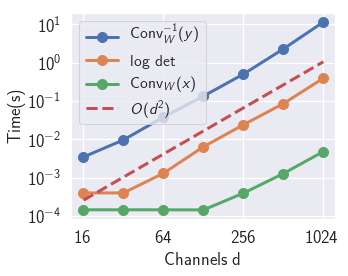

In [14]:

import seaborn as sns
sns.set()
from matplotlib import rc

rc('text', usetex=True)
rc('text.latex', preamble=[r'\usepackage{sansmath}', r'\sansmath']) #r'\usepackage{DejaVuSans}'
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans']})
#plt.rcParams.update({'font.size': 50})
#rc('xtick.major', pad=12)
#rc('ytick.major', pad=12)
rc('grid', linewidth=1.3)
ms=20
lw=3
fs = 18
plt.plot(channels,1e-6*inverse_times_c,label=r"Conv$_W^{-1}(y)$",marker='.',ms=ms,lw=lw)
plt.plot(channels,1e-6*logdet_times_c,label=r"$\log$ det ",marker='.',ms=ms,lw=lw)
plt.plot(channels,1e-6*conv_times_c,label=r"Conv$_W(x)$",marker='.',ms=ms,lw=lw)
plt.plot(channels,1e-6*channels**2,label=r"$O(d^2)$",ls='--',lw=lw)
#plt.plot(channels,6e-8*channels**3,label=r"$O(d^3)$",ls='--',lw=lw)
plt.xlabel("Channels d",fontsize=fs)
plt.ylabel(r"Time(s)",fontsize=fs)
plt.legend(fontsize=fs-2)
plt.yscale('log')
plt.xscale('log')
plt.xticks([16,64,256,1024], ["16", "64", "256", "1024"],fontsize=fs)
plt.yticks(fontsize=fs)

fig = plt.gcf()
fig.set_size_inches(5, 4)
plt.tight_layout()
fig.savefig('channels_runtime.pdf',bbox_layout="tight")

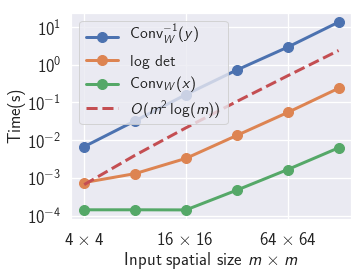

In [13]:
ms=20
lw=3
plt.plot(height,1e-6*inverse_times_h,label=r"Conv$_W^{-1}(y)$",marker='.',ms=ms,lw=lw)
plt.plot(height,1e-6*logdet_times_h,label=r"$\log$ det ",marker='.',ms=ms,lw=lw)
plt.plot(height,1e-6*conv_times_h,label=r"Conv$_W(x)$",marker='.',ms=ms,lw=lw)
#plt.plot(height,1e-4*height**2,label=r"$O(d^2)$",ls='--',lw=lw)
plt.plot(height,3e-5*np.log(height)*height**2,label=r"$O(m^2 \log(m))$",ls='--',lw=lw)
plt.xlabel(r"Input spatial size $m\times m$",fontsize=fs)
plt.ylabel(r"Time(s)",fontsize=fs)
plt.legend(fontsize=fs-2)
plt.yscale('log')
plt.xscale('log')
plt.xticks([4,16,64], [r"$4\times 4$",r"$16\times 16$",r"$64\times 64$"],fontsize=fs)
plt.yticks(fontsize=fs)
#plt.xlim([10,200])
fig = plt.gcf()
plt.tight_layout()
fig.set_size_inches(5, 4)
fig.savefig('hw_runtime.pdf',bbox_layout="tight")

In [ ]:
for c in [16,32,64,128]:
    Conv = iConv2d(c,c)
    x = torch.randn(bs,c,h,w)
    %timeit Conv(x)

In [ ]:
print(timeit.timeit('[func(42) for func in (f,g,h)]', globals=globals()))